# Convert a tree into ONNX

This notebook shows how to create a tree and execute it with [onnx](https://github.com/onnx/onnx) and [onnxruntime](https://onnxruntime.ai/docs/api/python/). The direct way to do it is simple to use ONNX API and more precisely, the node [TreeEnsembleRegressor](https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md#ai.onnx.ml.TreeEnsembleRegressor). Another option is to create a tree in [scikit-learn](https://scikit-learn.org/stable/) and then to convert it using [skl2onnx](https://onnx.ai/sklearn-onnx/).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## Tree and cython

Class [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) is the public API for a tree in scikit-learn. It relies one another implemented in [cython](https://cython.org/) called [Tree](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/tree/_tree.pyx#L490). This one is private and not supposed to be accessed by users. All methods cannot be accessed from python including the one used to add nodes [add_node](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/tree/_tree.pyx#L716). Then a little bit of cython is needed to actually create a tree... or we could use function [tree_add_node](http://www.xavierdupre.fr/app/mlinsights/helpsphinx/mlinsights/mltree/_tree_digitize.cpython-39-x86_64-linux-gnu.html).

In [3]:
from mlinsights.mltree._tree_digitize import tree_add_node
help(tree_add_node)

Help on built-in function tree_add_node in module mlinsights.mltree._tree_digitize:

tree_add_node(...)
    tree_add_node(tree, parent, is_left, is_leaf, feature, threshold, impurity, n_node_samples, weighted_n_node_samples)
    
    Adds a node to tree.
    
    :param parent: parent index (-1 for the root)
    :param is_left: is left node?
    :param is_leaf: is leave?
    :param feature: feature index
    :param threshold: threshold (or value)
    :param impurity: impurity
    :param n_node_samples: number of samples this node represents
    :param weighted_n_node_samples: node weight



## A simple problem

<ipython-input-4-09db879347c8>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z)


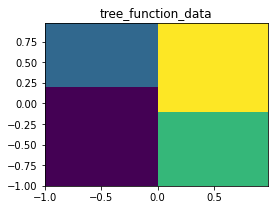

In [4]:
import numpy
import matplotlib.pyplot as plt


def plot_function(fct, title):
    x_min, x_max = -1, 1
    y_min, y_max = -1, 1
    h = 0.02  # step size in the mesh
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h),
                            numpy.arange(y_min, y_max, h))
    Z = fct(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.pcolormesh(xx, yy, Z)
    ax.set_title(title)
    return ax


def tree_function(x, y):
    if x <= 0:
        if y <= 0.2:
            return 0
        else:
            return 1
    else:
        if y <= -0.1:
            return 2
        else:
            return 3


def tree_function_data(xy):
    res = numpy.empty(xy.shape[0], dtype=numpy.float64)
    for i in range(0, xy.shape[0]):
        res[i] = tree_function(xy[i, 0], xy[i, 1])
    return res

        
plot_function(tree_function_data, "tree_function_data");

## The tree construction

The tree needs two features and has three nodes.

In [5]:
from sklearn.tree._tree import Tree

UNUSED = 99999

values = []  # stored the predicted values

tree = Tree(2,  # n_features
            numpy.array([1], dtype=numpy.intp),  #  n_classes
            1,  # n_outputs
            )


# First node: the root: x <= 0
index = tree_add_node(tree,
                      -1,          # parent index
                      False,       # is left node
                      False,       # is leaf
                      0,           # feature index
                      0,           # threshold
                      0, 1, 1.)    # impurity, n_node_samples, node weight
values.append(UNUSED)


# Second node: y <= 0.2
index1 = tree_add_node(tree,
                       index,       # parent index
                       True,        # is left node
                       False,       # is leaf
                       1,           # feature index
                       0.2,         # threshold
                       0, 1, 1.)    # impurity, n_node_samples, node weight
values.append(UNUSED)

# First leaf
leaf_1 = tree_add_node(tree,
                       index1,      # parent index
                       True,        # is left node
                       True,        # is leaf
                       0,           # feature index
                       0,           # threshold
                       0, 1, 1.)    # impurity, n_node_samples, node weight
values.append(0)

# Second leaf
leaf_2 = tree_add_node(tree, index1, False, True, 0, 0, 0, 1, 1.)
values.append(1)

# Third node: y <= -0.1
index2 = tree_add_node(tree,
                       index,       # parent index
                       False,       # is left node
                       False,       # is right node
                       1,           # feature index
                       -0.1,        # threshold
                       0, 1, 1.)    # impurity, n_node_samples, node weight
values.append(UNUSED)

# Thrid leaf
leaf_3 = tree_add_node(tree,
                       index2,      # parent index
                       True,        # is left node
                       True,        # is leaf
                       0,           # feature index
                       0,           # threshold
                       0, 1, 1.)    # impurity, n_node_samples, node weight
values.append(2)

# Fourth leaf
leaf_4 = tree_add_node(tree, index2, False, True, 0, 0, 0, 1, 1.)
values.append(3)


index, index1, index2, values

(0, 1, 4, [99999, 99999, 0, 1, 99999, 2, 3])

The final detail.

In [6]:
tree.max_depth = 2

The internal structure is created, let's complete the public API.

In [7]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor()
reg.tree_ = tree
reg.tree_.value[:, 0, 0] = numpy.array(  # pylint: disable=E1137
    values, dtype=numpy.float64)
reg.n_outputs = 1
reg.n_outputs_ = 1
reg.n_features_in_ = 2  # scikit-learn >= 0.24
reg.maxdepth = tree.max_depth

reg

DecisionTreeRegressor()

<ipython-input-4-09db879347c8>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z)


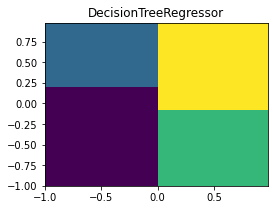

In [8]:
plot_function(reg.predict, "DecisionTreeRegressor");

It is the same.

## Conversion to ONNX

The only difference is ONNX does not support double (float64) in opset 15 or below with  [TreeEnsembleRegressor](https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md#ai.onnx.ml.TreeEnsembleRegressor). It does not really matter for this example but it could (see this example [Discrepancies](http://www.xavierdupre.fr/app/onnxcustom/helpsphinx/gyexamples/plot_ebegin_float_double.html)).

In [9]:
from skl2onnx import to_onnx

feat = numpy.empty((1, 2), dtype=numpy.float32)
onx = to_onnx(reg, feat, target_opset=14)

%onnxview onx

And we execute it with onnxruntime.

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.4'


<ipython-input-4-09db879347c8>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z)


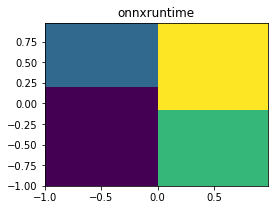

In [10]:
from onnxruntime import InferenceSession

sess = InferenceSession(onx.SerializeToString())

plot_function(lambda x: sess.run(None, {'X': x.astype(numpy.float32)})[0], "onnxruntime");

Still the same.

## Text visualization

This can be useful to debug a function building a tree.

See [onnx_text_plot_tree](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/mlprodict/plotting/text_plot.html#mlprodict.plotting.text_plot.onnx_text_plot_tree), [export_text](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html?highlight=export_text#sklearn.tree.export_text), [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html?highlight=plot_tree#sklearn.tree.plot_tree).

In [11]:
from mlprodict.plotting.text_plot import onnx_text_plot_tree

print(onnx_text_plot_tree(onx.graph.node[0]))

n_targets=1
n_trees=1
----
treeid=0
 X0 <= 0.0
   F X1 <= -0.1
      F y=3.0 f=0 i=6
      T y=2.0 f=0 i=5
   T X1 <= 0.19999999
      F y=1.0 f=0 i=3
      T y=0.0 f=0 i=2


In [12]:
from sklearn.tree import export_text

print(export_text(reg))

|--- feature_0 <= 0.00
|   |--- feature_1 <= 0.20
|   |   |--- value: [0.00]
|   |--- feature_1 >  0.20
|   |   |--- value: [1.00]
|--- feature_0 >  0.00
|   |--- feature_1 <= -0.10
|   |   |--- value: [2.00]
|   |--- feature_1 >  -0.10
|   |   |--- value: [3.00]



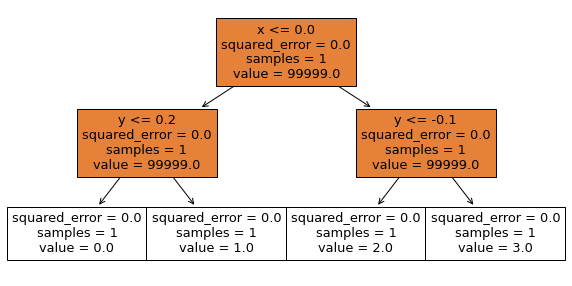

In [13]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(10,5))
plot_tree(reg, feature_names=['x', 'y'], filled=True);